In [1]:
import os
import itertools
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense , Flatten , MaxPooling2D, Activation
print("modules loaded")

2025-11-20 04:29:22.224202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-20 04:29:22.224368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-20 04:29:22.358459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [4]:
data_dir=("/kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test")
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    file_path=os.path.join(data_dir,fold)
    fpath=os.listdir(file_path)
    for f in fpath:
        fil_path=os.path.join(file_path,f)
        filepath.append(fil_path) 
        labels.append(fold)
F_series=pd.Series(filepath,name="filepath")
L_series=pd.Series(labels,name="labels")
df=pd.concat([F_series,L_series],axis=1)

In [5]:
df.head()

,filepath,labels
0,/kaggle/input/retinal-oct-c8/RetinalOCT_Datase...,DR
1,/kaggle/input/retinal-oct-c8/RetinalOCT_Datase...,DR
2,/kaggle/input/retinal-oct-c8/RetinalOCT_Datase...,DR
3,/kaggle/input/retinal-oct-c8/RetinalOCT_Datase...,DR
4,/kaggle/input/retinal-oct-c8/RetinalOCT_Datase...,DR


In [6]:
counts=df["labels"].value_counts()
counts

labels
DR        350
AMD       350
CSR       350
DRUSEN    350
CNV       350
NORMAL    350
MH        350
DME       350
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  2800 non-null   object
 1   labels    2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


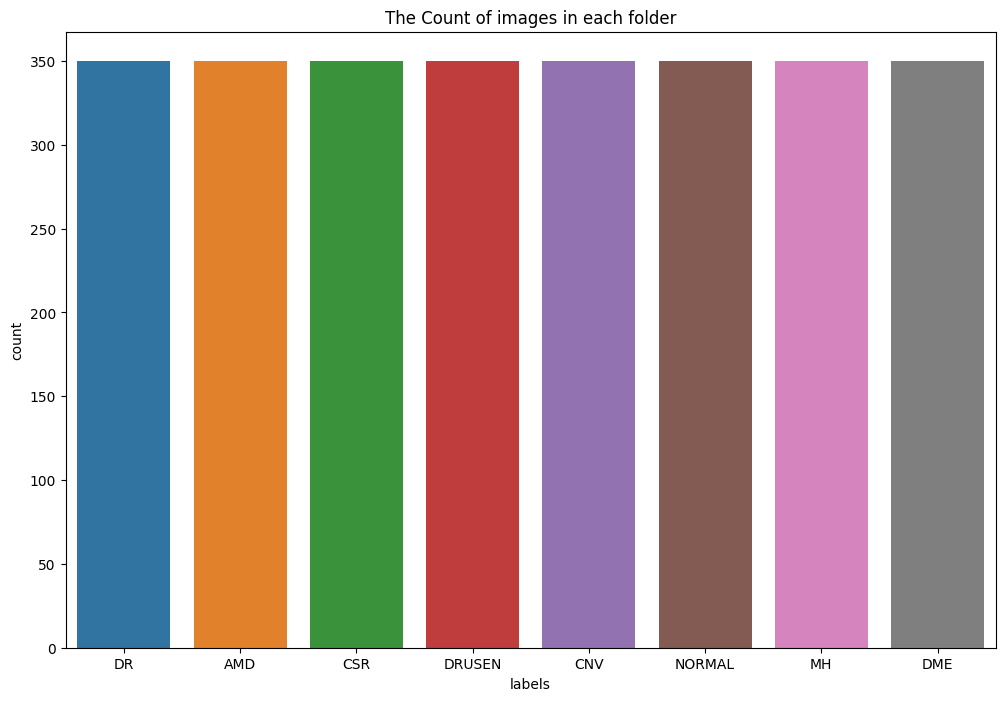

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(x=counts.index,y=counts.values)
plt.title('The Count of images in each folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

In [9]:
train_df,dummy_df=train_test_split(df,train_size=0.8,random_state=42,stratify=df["labels"])
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=dummy_df["labels"])

In [10]:
batch_size=16
image_size=(224,224)
channels=3
image_shape=(image_size[0],image_size[1],channels)
tr_gen=ImageDataGenerator()
ts_gen=ImageDataGenerator()
train_gen=tr_gen.flow_from_dataframe(train_df,x_col="filepath",y_col="labels",
                                    target_size=image_size,class_mode="categorical",color_mode="rgb",
                                   batch_size=batch_size)
valid_gen=ts_gen.flow_from_dataframe(valid_df,x_col="filepath",y_col="labels",
                                    target_size=image_size,class_mode="categorical",color_mode="rgb",
                                   batch_size=batch_size)
test_gen=ts_gen.flow_from_dataframe(test_df,x_col="filepath",y_col="labels",
                                    target_size=image_size,class_mode="categorical",color_mode="rgb",
                                   batch_size=batch_size)

Found 2240 validated image filenames belonging to 8 classes.
Found 280 validated image filenames belonging to 8 classes.
Found 280 validated image filenames belonging to 8 classes.


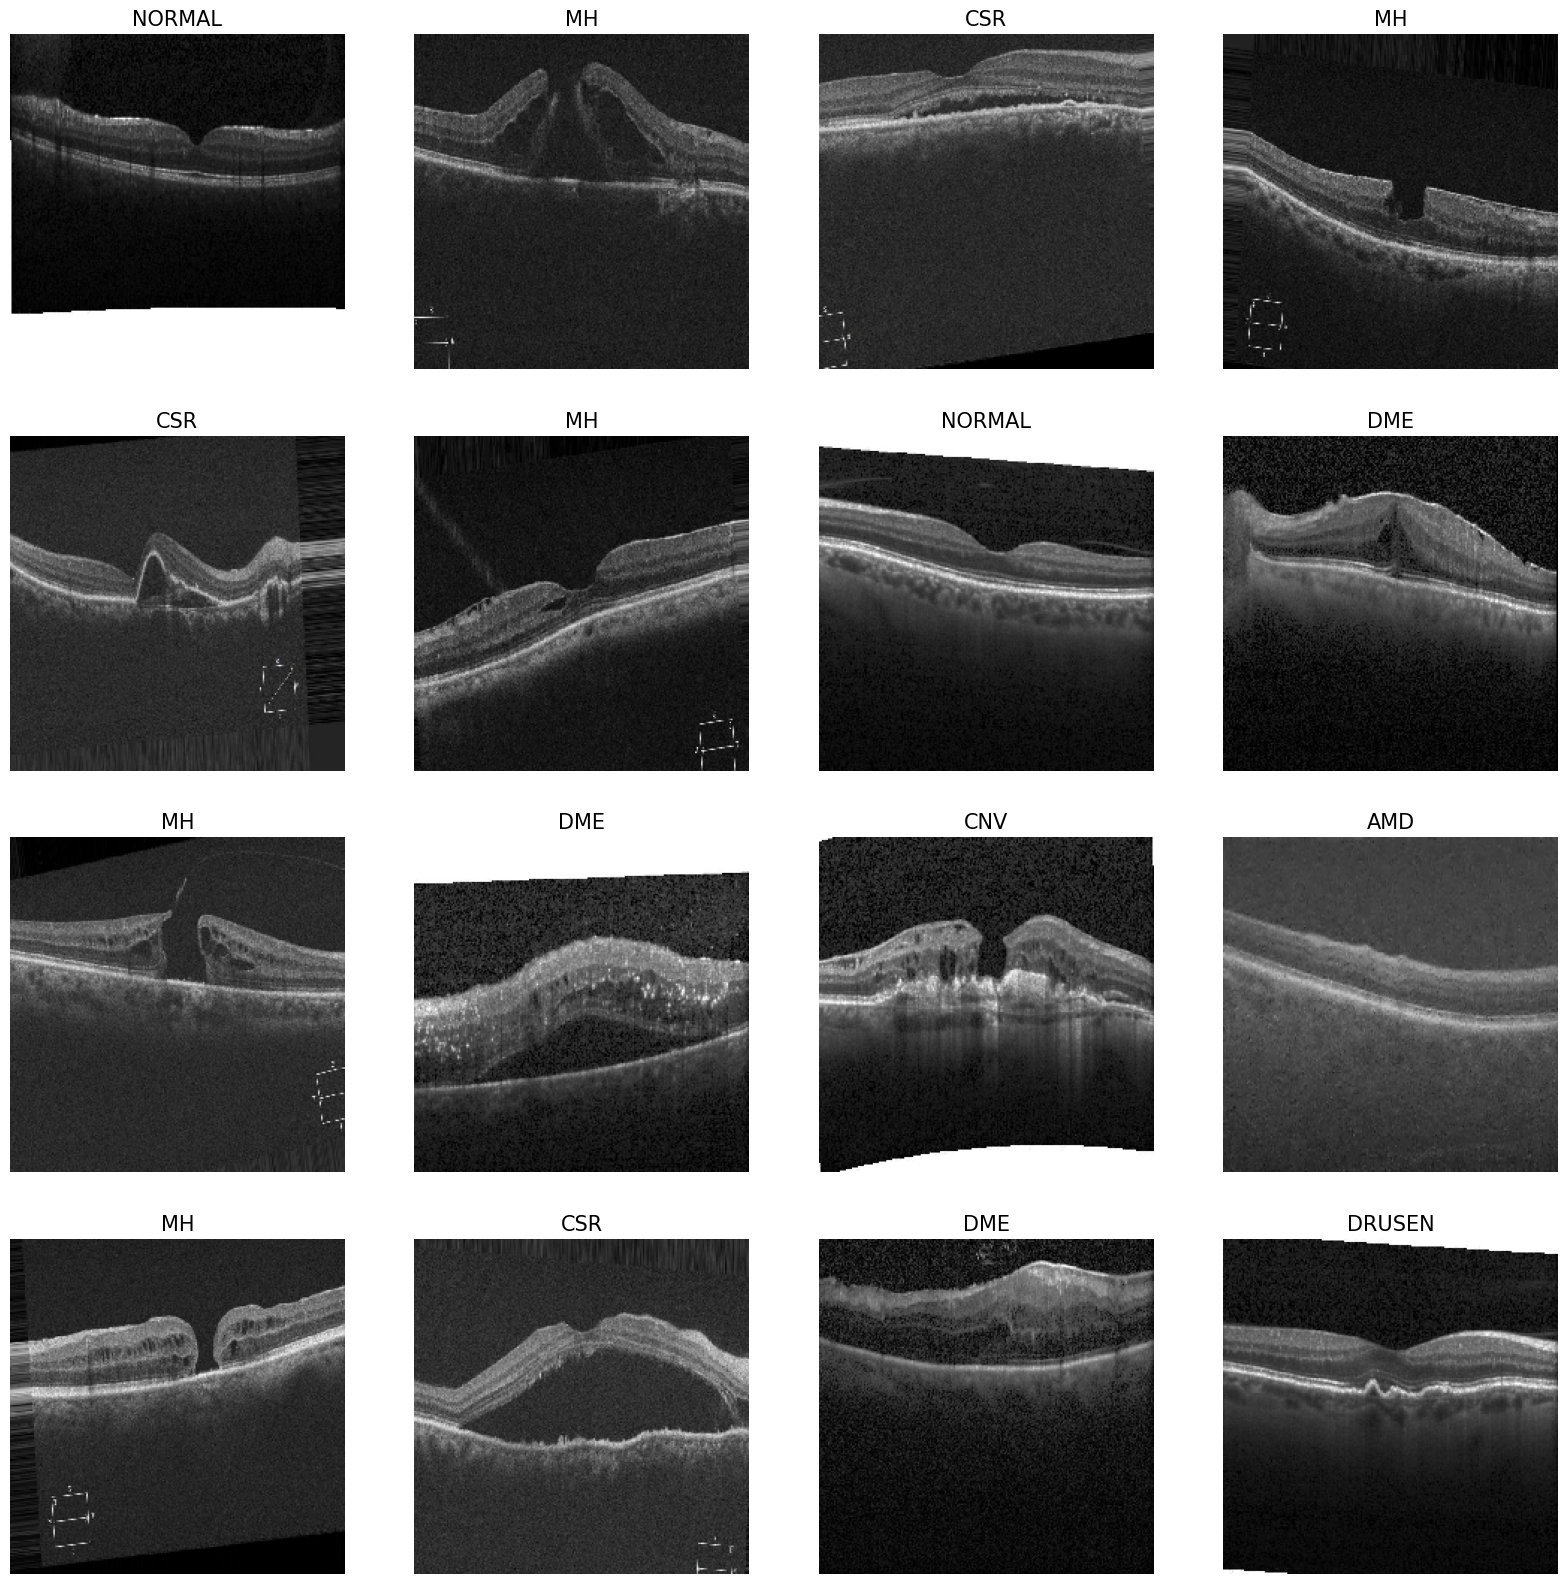

In [11]:
g_dict=train_gen.class_indices
classes=list(g_dict.keys())
images,labels=next(train_gen)
plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image=images[i]/255
    plt.imshow(image)
    index=np.argmax(labels[i])
    classes_name=classes[index]
    plt.title(classes_name,color='black',fontsize=15)
    plt.axis('off')
    
plt.show()

In [12]:
batch_size=16
image_size=(224,224)
channel=3
image_shape=(image_size[0],image_size[1],channel)
class_count=len(list(classes))
model=Sequential([
    Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=image_shape),
    Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
    Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
    Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
    Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
    Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
    Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),
    Dense(class_count,activation='softmax')
])
model.compile(optimizer=Adamax(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,870,600 (205.50 MB)

 Trainable params: 53,870,600 (205.50 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history=model.fit(train_gen ,epochs=10 ,verbose= 1 ,validation_data=valid_gen)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-11-20 04:32:01.605177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2025-11-20 04:32:01.605262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2025-11-20 04:32:01.605273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2025-11-20 04:32:01.605283: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2025-11-20 04:32:01.605292: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1

  1/140 ━━━━━━━━━━━━━━━━━━━━ 52:54 23s/step - accuracy: 0.1250 - loss: 9.4070

I0000 00:00:1763613137.702179     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1763613137.722403     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1873 - loss: 26.5990

W0000 00:00:1763613163.921184     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2025-11-20 04:32:46.973486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.39009, expected 3.53025
2025-11-20 04:32:46.973565: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.40727, expected 4.54742
2025-11-20 04:32:46.973577: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.56026, expected 4.70042
2025-11-20 04:32:46.973586: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.58812, expected 4.72827
2025-11-20 04:32:46.973596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.9643, expected 4.10445
2025-11-20 04:32:46.973605: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.19898, expected 4.33914
2025-11-20 04:32:46.973614: E external/loc

140/140 ━━━━━━━━━━━━━━━━━━━━ 56s 240ms/step - accuracy: 0.1877 - loss: 26.4638 - val_accuracy: 0.3643 - val_loss: 587.6744
Epoch 2/10


W0000 00:00:1763613171.131001     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.4008 - loss: 1.4392 - val_accuracy: 0.4679 - val_loss: 934.9163
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5055 - loss: 1.1488 - val_accuracy: 0.4536 - val_loss: 1043.9324
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5752 - loss: 1.0073 - val_accuracy: 0.4464 - val_loss: 429.1881
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6912 - loss: 0.7828 - val_accuracy: 0.4857 - val_loss: 493.0411
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7493 - loss: 0.6450 - val_accuracy: 0.4929 - val_loss: 1044.2074
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.8526 - loss: 0.4018 - val_accuracy: 0.5321 - val_loss: 1096.2167
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9114 - loss: 0.2528 - val_accuracy: 0.4643 - val_loss: 1615.8678
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.9423 - 

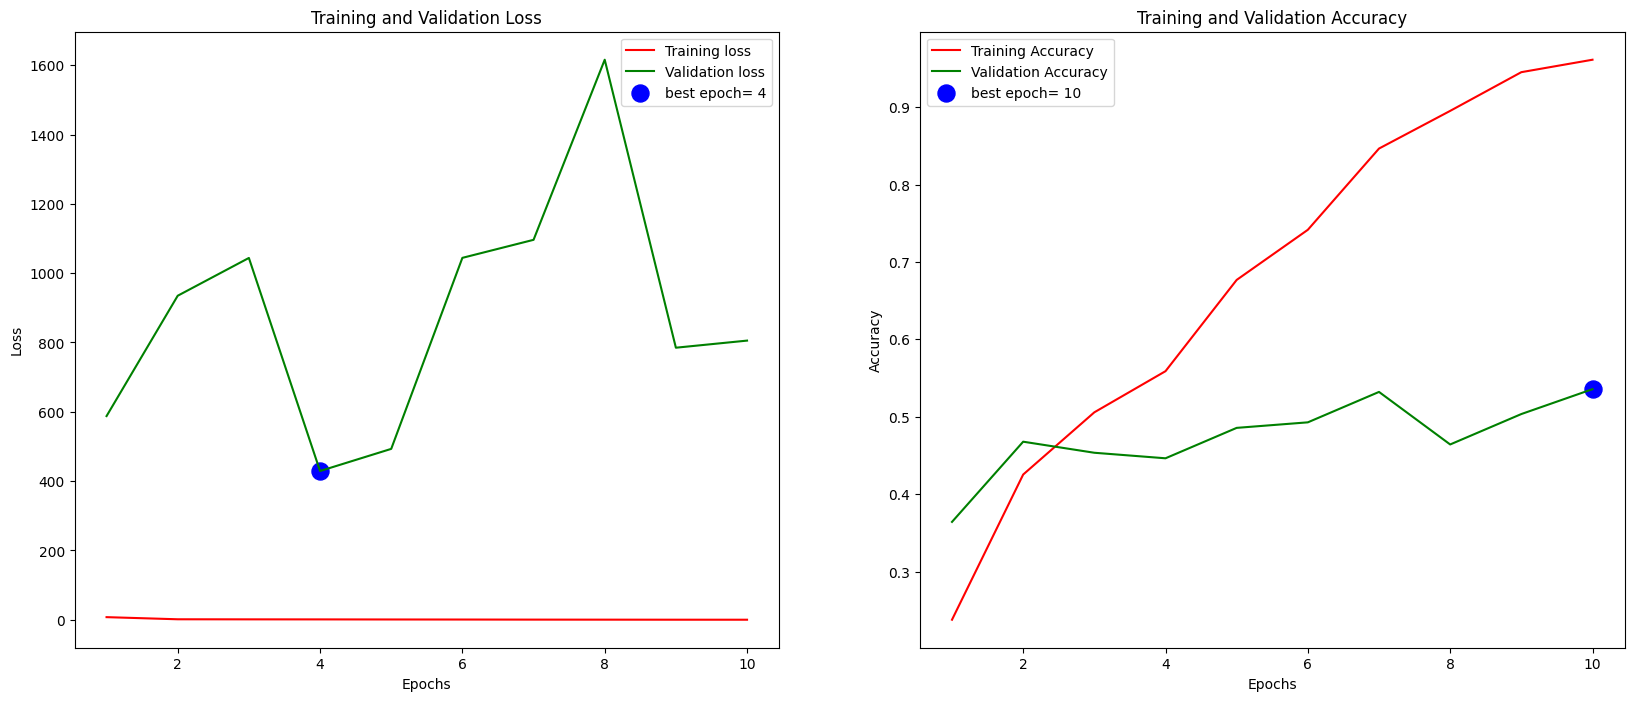

In [14]:
tr_acc=history.history['accuracy']
tr_loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
index_loss=np.argmin(val_loss)
val_lowest=val_loss[index_loss]
index_acc=np.argmax(val_acc)
acc_highest=val_acc[index_acc]
Epochs=[i+1 for i in range(len(tr_acc))]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [15]:
train_score=model.evaluate(train_gen , verbose=1)
valid_score=model.evaluate(valid_gen, verbose=1)
test_score=model.evaluate(test_gen , verbose=1)

print("train loss : ",train_score[0])
print("train accuracy : ", train_score[1])
print("-"*30)
print("valid loss : ",valid_score[0])
print("valid accuracy : ", valid_score[1])
print("-"*30)
print("test loss : ",test_score[0])
print("test accuracy : ", test_score[1])

140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9930 - loss: 0.0299
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5292 - loss: 119.1091
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5319 - loss: 67.8578
train loss :  0.03378475084900856
train accuracy :  0.9924107193946838
------------------------------
valid loss :  1110.3790283203125
valid accuracy :  0.5357142686843872
------------------------------
test loss :  626.1474609375
test accuracy :  0.5464285612106323


In [16]:
preds=model.predict(test_gen)
y_pred=np.argmax(preds,axis=1)

 4/18 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 

W0000 00:00:1763613370.260601     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


W0000 00:00:1763613371.957980     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


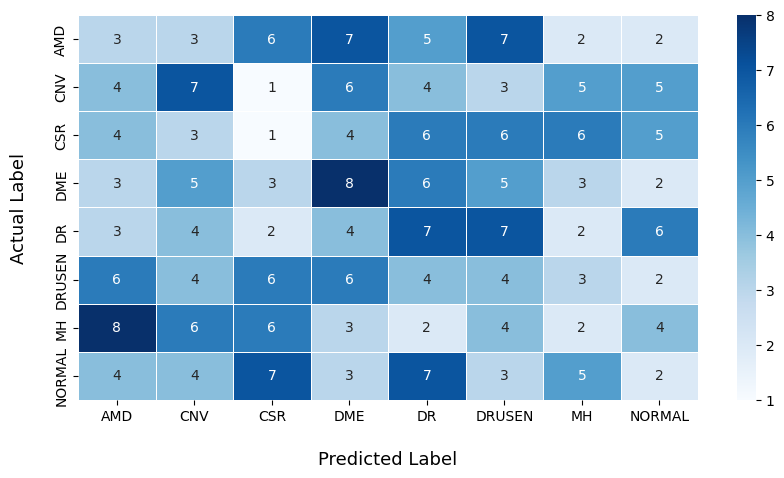

In [17]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [18]:
model.save("Trained_Model.keras")

In [19]:
model.save("Trained_Model.h5")

In [20]:
model = tf.keras.models.load_model("Trained_Model.h5")

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,870,602 (205.50 MB)

 Trainable params: 53,870,600 (205.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)